In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
from scipy.stats import t as scipy_t
import math
from scipy.stats import gaussian_kde

In [ ]:

def normal_icdf(x):
    x = torch.clamp(x, 1e-6, 1.0 - 1e-6)
    return torch.sqrt(torch.tensor(2.0)) * torch.erfinv(2 * x - 1)

def normal_cdf(x):
    return 0.5 * (1 + torch.erf(x / torch.sqrt(torch.tensor(2.0))))

class GaussianCopula(nn.Module):
    def __init__(self, init_rho=0.0):
        super().__init__()
        # Use arctanh for initialization to ensure proper scaling
        if abs(init_rho) >= 0.99:
            init_val = np.sign(init_rho) * 2.0
        else:
            init_val = np.arctanh(init_rho)
        self.rho_param = nn.Parameter(torch.tensor([init_val], dtype=torch.float32))

    def get_rho(self):
        return torch.tanh(self.rho_param)

    def forward(self, u, v):
        rho = self.get_rho()
        x, y = normal_icdf(u), normal_icdf(v)

        # Improved computation of the bivariate Gaussian copula density
        z = (x**2 + y**2 - 2 * rho * x * y) / (1 - rho**2)
        numerator = torch.exp(-0.5 * (z - x**2 - y**2))
        denominator = torch.sqrt(1 - rho**2)

        # Apply clamping for numerical stability
        density = numerator / denominator
        return density

    def h_function(self, v, u):
        rho = self.get_rho()
        x, y = normal_icdf(u), normal_icdf(v)
        denom = torch.sqrt(1 - rho**2)
        return normal_cdf((y - rho * x) / denom)

    def hinv_function(self, w, u):
        rho = self.get_rho()
        x = normal_icdf(u)
        denom = torch.sqrt(1 - rho**2)
        y = rho * x + denom * normal_icdf(w)
        return normal_cdf(y)



In [ ]:
def simulate_data(n_samples=1000, seed=42, marginals=None, correlation_matrix=None):
    # Generate multivariate normal samples
    cov = correlation_matrix
    mvn = torch.distributions.MultivariateNormal(torch.zeros(len(marginals)), cov)
    samples = mvn.sample((n_samples,))
    u_samples = normal_cdf(samples)
    mixed_samples = torch.zeros((n_samples, len(marginals)))
    u_transformed = torch.zeros_like(mixed_samples)

    # Transform to desired marginals
    for i, marginal in enumerate(marginals):
        dist_type = marginal['type']
        params = marginal['params']

        if dist_type == 'normal':
            loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.norm.ppf(uk.item(), loc, scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.norm.cdf(xk.item(), loc, scale) for xk in mixed_samples[:, i]])

        elif dist_type == 't':
            loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
            df = params.get('df', 3)  # Degrees of freedom
            mixed_samples[:, i] = torch.tensor([stats.t.ppf(uk.item(), df, loc, scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.t.cdf(xk.item(), df, loc, scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'gumbel':
            loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.gumbel_r.ppf(uk.item(), loc, scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.gumbel_r.cdf(xk.item(), loc, scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'beta':
            a, b = params.get('a', 2.0), params.get('b', 2.0)
            mixed_samples[:, i] = torch.tensor([stats.beta.ppf(uk.item(), a, b) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.beta.cdf(xk.item(), a, b) for xk in mixed_samples[:, i]])

        elif dist_type == 'gamma':
            a, scale = params.get('a', 2.0), params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.gamma.ppf(uk.item(), a, scale=scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.gamma.cdf(xk.item(), a, scale=scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'exponential':
            scale = params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.expon.ppf(uk.item(), scale=scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.expon.cdf(xk.item(), scale=scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'uniform':
            loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.uniform.ppf(uk.item(), loc, scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.uniform.cdf(xk.item(), loc, scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'lognormal':
            s = params.get('s', 1.0)  # sigma parameter (shape)
            scale = params.get('scale', 1.0)  # scale parameter (exp(mu))
            mixed_samples[:, i] = torch.tensor([stats.lognorm.ppf(uk.item(), s, scale=scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.lognorm.cdf(xk.item(), s, scale=scale) for xk in mixed_samples[:, i]])

        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")

    return u_transformed, mixed_samples, marginals




In [ ]:
%%time
Ncopula = 3
custom_marginals = generate_random_marginals(Ncopula)
correlation_matrix = torch.abs(generate_correlation_matrix(Ncopula))

n_samples = 3000
# data, mixed_samples, marginals = simulate_data(n_samples, marginals=custom_marginals, correlation_matrix = correlation_matrix)
# data, mixed_samples, marginals = simulate_data_bimodal(n_samples, marginals=None, correlation_matrix = correlation_matrix)
# data, mixed_samples, marginals = simulate_clayton_data(n_samples=1000, seed=42, marginals=None)


Epoch 0, Loss: 0.0000
Epoch 200, Loss: -0.3530
Epoch 400, Loss: -0.5864
Epoch 600, Loss: -0.7675
Epoch 800, Loss: -0.8999
Epoch 1000, Loss: -0.9839
Epoch 1200, Loss: -1.0358
Epoch 1400, Loss: -1.0677
Epoch 1600, Loss: -1.0842
Epoch 1800, Loss: -1.0904
Epoch 2000, Loss: -1.0920
Epoch 2200, Loss: -1.0923
Epoch 2400, Loss: -1.0924
Epoch 2600, Loss: -1.0924
Epoch 2800, Loss: -1.0924
Original data rank correlations:
[[0.         0.79774548 0.79307315]
 [0.79774548 0.         0.74062644]
 [0.79307315 0.74062644 0.        ]]

Generated data rank correlations:
[[0.         0.80159764 0.79472457]
 [0.80159764 0.         0.73120147]
 [0.79472457 0.73120147 0.        ]]
CPU times: user 53.5 s, sys: 599 ms, total: 54.1 s
Wall time: 56.3 s


In [ ]:
learning_rate = 0.001
epochs = 3000

model = NDimensionalCVineCopula(Ncopula, GaussianCopula)
# model = NDimensionalCVineCopula(Ncopula, CCopula)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    density = model(data)
    loss = -torch.mean(torch.log(density))
    loss.backward()
    optimizer.step()
    current_loss = loss.item()
    losses.append(current_loss)
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {current_loss:.4f}")

# Generate samples from the model
u_samples = model.sample(n_samples)

# Calculate and compare rank correlations
original_corr = np.zeros((Ncopula, Ncopula))
generated_corr = np.zeros((Ncopula, Ncopula))
for i in range(Ncopula):
    for j in range(Ncopula):
        if i != j:
            original_corr[i, j] = stats.spearmanr(data[:, i].numpy(), data[:, j].numpy())[0]
            generated_corr[i, j] = stats.spearmanr(u_samples[:, i].detach().numpy(), u_samples[:, j].detach().numpy())[0]

print("Original data rank correlations:")
print(original_corr)
print("\nGenerated data rank correlations:")
print(generated_corr)



Epoch 0, Loss: 0.0000
Epoch 200, Loss: -0.2648
Epoch 400, Loss: -0.5834
Epoch 600, Loss: -1.0359
Epoch 800, Loss: -1.5318
Epoch 1000, Loss: -1.8491
Epoch 1200, Loss: -1.9676
Epoch 1400, Loss: -2.0205
Epoch 1600, Loss: -2.0419
Epoch 1800, Loss: -2.0480
Epoch 2000, Loss: -2.0493
Epoch 2200, Loss: -2.0495
Epoch 2400, Loss: -2.0495
Epoch 2600, Loss: -2.0495
Epoch 2800, Loss: -2.0495
Original data rank correlations:
[[0.         0.74021275 0.72874116]
 [0.74021275 0.         0.13963308]
 [0.72874116 0.13963308 0.        ]]

Generated data rank correlations:
[[0.         0.72803312 0.7026293 ]
 [0.72803312 0.         0.08722929]
 [0.7026293  0.08722929 0.        ]]


In [ ]:
Ncopula = 3
custom_marginals = generate_random_marginals2(Ncopula)
correlation_matrix = torch.abs(generate_correlation_matrix(Ncopula))

n_samples = 3000
data, mixed_samples, marginals = simulate_data2(n_samples, marginals=custom_marginals, correlation_matrix = correlation_matrix)

In [ ]:
np.shape(mixed_samples), custom_marginals

(torch.Size([3000, 3]),
 [{'name': 'Exp(λ=0.77)',
   'type': 'exponential',
   'params': {'scale': 1.2964358102005786}},
  {'name': 'Beta(α=2.90, β=1.60)',
   'type': 'beta',
   'params': {'a': 2.903629446633686, 'b': 1.601649163181418}},
  {'name': 'BimodalNormal(μ1=-3.10, σ1=1.49, w1=0.56, μ2=3.78, σ2=1.09, w2=0.44)',
   'type': 'bimodal_normal',
   'params': {'loc1': -3.102722791211761,
    'scale1': 1.4863803558275739,
    'weight1': 0.5559999039416371,
    'loc2': 3.784748718873231,
    'scale2': 1.089998526286837,
    'weight2': 0.4440000960583629}}])

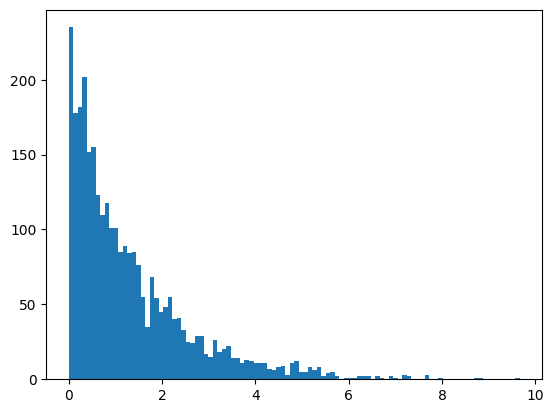

In [ ]:
plt.hist(mixed_samples[:,0],bins=100);

In [ ]:
import random
import numpy as np

def generate_random_marginals2(n_distributions, seed=None):
    """
    Generate random marginal distribution specifications.

    Parameters:
    -----------
    n_distributions : int
        Number of random distributions to generate

    seed : int or None, optional (default=None)
        Random seed for reproducibility

    Returns:
    --------
    marginal_specs : list of dict
        List of dictionaries specifying the marginal distributions
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Available distribution types
    dist_types = [
        'normal',
        'exponential',
        'beta',
        'gamma',
        't',
        'uniform',
        'lognormal',
        'bimodal_normal',  # Added bimodal normal
    ]

    marginal_specs = []

    for i in range(n_distributions):
        # Randomly select a distribution type
        dist_type = random.choice(dist_types)

        # Generate random parameters based on the distribution type
        if dist_type == 'normal' or dist_type == 'gaussian':
            params = {
                'loc': random.uniform(-5, 5),
                'scale': random.uniform(0.1, 3)
            }
            name = f"Normal(μ={params['loc']:.2f}, σ={params['scale']:.2f})"

        elif dist_type == 'exponential':
            params = {
                'scale': random.uniform(0.2, 2)
            }
            name = f"Exp(λ={1/params['scale']:.2f})"

        elif dist_type == 'beta':
            params = {
                'a': random.uniform(0.5, 5),
                'b': random.uniform(0.5, 5)
            }
            name = f"Beta(α={params['a']:.2f}, β={params['b']:.2f})"

        elif dist_type == 'gamma':
            params = {
                'shape': random.uniform(0.5, 5),
                'scale': random.uniform(0.5, 2)
            }
            name = f"Gamma(k={params['shape']:.2f}, θ={params['scale']:.2f})"

        elif dist_type == 't':
            params = {
                'loc': random.uniform(-2, 2),
                'scale': random.uniform(0.5, 2),
                'df': random.randint(2, 10)
            }
            name = f"t(df={params['df']}, μ={params['loc']:.2f}, σ={params['scale']:.2f})"

        elif dist_type == 'uniform':
            loc = random.uniform(-5, 5)
            width = random.uniform(1, 5)
            params = {
                'loc': loc,
                'scale': width
            }
            name = f"Uniform({loc:.2f}, {loc+width:.2f})"

        elif dist_type == 'lognormal':
            params = {
                's': random.uniform(0.1, 1),
                'scale': random.uniform(0.5, 2)
            }
            name = f"LogNormal(σ={params['s']:.2f}, scale={params['scale']:.2f})"

        elif dist_type == 'bimodal_normal':
            # Generate random parameters for bimodal normal
            # First mode
            loc1 = random.uniform(-5, 0)
            scale1 = random.uniform(0.2, 1.5)
            weight1 = random.uniform(0.3, 0.7)

            # Second mode - ensure some separation between modes
            loc2 = random.uniform(1, 6)  # Positive values to ensure separation
            scale2 = random.uniform(0.2, 1.5)
            weight2 = 1 - weight1  # Weights sum to 1

            params = {
                'loc1': loc1,
                'scale1': scale1,
                'weight1': weight1,
                'loc2': loc2,
                'scale2': scale2,
                'weight2': weight2
            }

            name = f"BimodalNormal(μ1={loc1:.2f}, σ1={scale1:.2f}, w1={weight1:.2f}, μ2={loc2:.2f}, σ2={scale2:.2f}, w2={weight2:.2f})"

        marginal_specs.append({
            'name': name,
            'type': dist_type,
            'params': params
        })

    return marginal_specs



In [ ]:
def visualize_mixed_data2(mixed_samples, u_transformed, model=None, marginals=None):
    """Visualize mixed data with different marginal distributions in a grid of plots."""
    import matplotlib.pyplot as plt
    from scipy import stats
    import numpy as np
    import torch

    n_vars = len(marginals)

    # Create a grid of subplots
    fig, axes = plt.subplots(n_vars, n_vars, figsize=(n_vars*2, n_vars*2))
    var_names = [f'X{i+1} ({m["name"]})' for i, m in enumerate(marginals)]

    # Helper function for bimodal normal PDF
    def bimodal_normal_pdf(x, params):
        loc1, scale1, weight1 = params.get('loc1', -2.0), params.get('scale1', 0.8), params.get('weight1', 0.5)
        loc2, scale2, weight2 = params.get('loc2', 2.0), params.get('scale2', 0.8), params.get('weight2', 0.5)

        # Normalize weights to ensure they sum to 1
        total_weight = weight1 + weight2
        weight1, weight2 = weight1/total_weight, weight2/total_weight

        # Compute the mixture of two Gaussians
        pdf1 = stats.norm.pdf(x, loc=loc1, scale=scale1)
        pdf2 = stats.norm.pdf(x, loc=loc2, scale=scale2)
        return weight1 * pdf1 + weight2 * pdf2

    # Helper function for bimodal normal inverse CDF (PPF)
    def bimodal_normal_ppf(u, params, n_samples):
        # This function implements the inverse CDF for a bimodal normal distribution
        # using binary search since there's no closed-form solution

        loc1, scale1, weight1 = params.get('loc1', -2.0), params.get('scale1', 0.8), params.get('weight1', 0.5)
        loc2, scale2, weight2 = params.get('loc2', 2.0), params.get('scale2', 0.8), params.get('weight2', 0.5)

        # Normalize weights
        total_weight = weight1 + weight2
        weight1, weight2 = weight1/total_weight, weight2/total_weight

        # Define CDF function for bimodal normal
        def bimodal_cdf(x):
            cdf1 = stats.norm.cdf(x, loc=loc1, scale=scale1)
            cdf2 = stats.norm.cdf(x, loc=loc2, scale=scale2)
            return weight1 * cdf1 + weight2 * cdf2

        # Implement binary search for each quantile
        result = []
        for uk in u:
            uk_val = uk.item()

            # Set reasonable search bounds
            lower = min(loc1 - 4*scale1, loc2 - 4*scale2)
            upper = max(loc1 + 4*scale1, loc2 + 4*scale2)

            # Handle edge cases
            if uk_val <= 0.0:
                result.append(lower)
                continue
            if uk_val >= 1.0:
                result.append(upper)
                continue

            # Binary search
            tol = 1e-6
            max_iter = 100

            for _ in range(max_iter):
                mid = (lower + upper) / 2
                cdf_mid = bimodal_cdf(mid)

                if abs(cdf_mid - uk_val) < tol:
                    result.append(mid)
                    break
                elif cdf_mid < uk_val:
                    lower = mid
                else:
                    upper = mid

                if _ == max_iter - 1:  # Last iteration
                    result.append((lower + upper) / 2)

        return torch.tensor(result, dtype=torch.float32)

    # Define distribution PDF and CDF mapping functions
    dist_funcs = {
        'exponential': {
            'pdf': lambda x, p: stats.expon.pdf(x, scale=p.get('scale', 1.0)),
            'ppf': lambda u, p, n: -torch.log(1 - u) * p.get('scale', 1.0)
        },
        'beta': {
            'pdf': lambda x, p: stats.beta.pdf(x, p.get('a', 1.0), p.get('b', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.beta.ppf(uk.item(), p.get('a', 1.0), p.get('b', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        't': {
            'pdf': lambda x, p: stats.t.pdf(x, p.get('df', 5)),
            'ppf': lambda u, p, n: torch.tensor([stats.t.ppf(uk.item(), p.get('df', 5))
                                               for uk in u], dtype=torch.float32)
        },
        'gamma': {
            'pdf': lambda x, p: stats.gamma.pdf(x, p.get('shape', 1.0), scale=p.get('scale', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.gamma.ppf(uk.item(), p.get('shape', 1.0), scale=p.get('scale', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        'normal': {
            'pdf': lambda x, p: stats.norm.pdf(x, p.get('loc', 0.0), p.get('scale', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.norm.ppf(uk.item(), p.get('loc', 0.0), p.get('scale', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        'lognormal': {
            'pdf': lambda x, p: stats.lognorm.pdf(x, s=p.get('s', 1.0), scale=p.get('scale', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.lognorm.ppf(uk.item(), s=p.get('s', 1.0), scale=p.get('scale', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        'weibull': {
            'pdf': lambda x, p: stats.weibull_min.pdf(x, p.get('c', 1.0), scale=p.get('scale', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.weibull_min.ppf(uk.item(), p.get('c', 1.0), scale=p.get('scale', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        'uniform': {
            'pdf': lambda x, p: stats.uniform.pdf(x, p.get('loc', 0.0), p.get('scale', 1.0) ),
            'ppf': lambda u, p, n: p.get('loc', 0.0) + p.get('scale', 1.0) * u
        },
        'bimodal_normal': {
            'pdf': bimodal_normal_pdf,
            'ppf': bimodal_normal_ppf
        },
        # Alias for compatibility
        'bimodal_gaussian': {
            'pdf': bimodal_normal_pdf,
            'ppf': bimodal_normal_ppf
        }
    }

    # Generate samples from model if provided
    if model is not None:
        with torch.no_grad():
            n_samples = len(mixed_samples)
            u_samples = model.sample(n_samples)

            # Transform uniform samples to match original distributions
            mixed_generated = torch.zeros_like(mixed_samples)

            for var_idx in range(n_vars):
                dist_type = marginals[var_idx]['type'].lower()
                params = marginals[var_idx]['params']

                # Get the appropriate ppf function or default to normal
                ppf_func = dist_funcs.get(dist_type, {}).get('ppf',
                                        lambda u, p, n: torch.tensor([stats.norm.ppf(uk.item(), 0, 1)
                                                                     for uk in u], dtype=torch.float32))

                # Apply inverse CDF transformation
                mixed_generated[:, var_idx] = ppf_func(u_samples[:, var_idx], params, n_samples)

    # Plot the grid
    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j] if n_vars > 1 else axes

            if i == j:  # Diagonal: histogram and PDF
                # Plot histogram of actual data
                ax.hist(mixed_samples[:, i].numpy(), bins=25, alpha=0.4, density=True, color='blue', label='Original')

                # Plot histogram of generated data if available
                if model is not None:
                    ax.hist(mixed_generated[:, i].numpy(), bins=25, alpha=0.4, density=True, color='red', label='Generated')

                if marginals is not None:
                    try:
                        # Generate x values for PDF plotting
                        x_min, x_max = np.min(mixed_samples[:, i].numpy()), np.max(mixed_samples[:, i].numpy())
                        x_range = x_max - x_min
                        x = np.linspace(x_min - 0.1*x_range, x_max + 0.1*x_range, 1000)

                        # Get distribution type and parameters
                        dist_type = marginals[i]['type'].lower()
                        params = marginals[i]['params']

                        # Get the appropriate pdf function or default to None
                        pdf_func = dist_funcs.get(dist_type, {}).get('pdf')

                        # Plot the PDF if available
                        if pdf_func is not None:
                            pdf = pdf_func(x, params)
                            ax.plot(x, pdf, 'k-', lw=2, label='Theoretical PDF')
                            ax.legend(loc='best', fontsize='small')
                    except Exception as e:
                        print(f"Error plotting PDF for {var_names[i]}: {e}")

                ax.set_title(var_names[i])
                ax.grid(True, alpha=0.3)

            else:  # Off-diagonal: scatter plots
                # Plot original data
                ax.scatter(
                    mixed_samples[:, j].numpy(),
                    mixed_samples[:, i].numpy(),
                    alpha=0.5, s=5, color='blue', label='Original'
                )

                # Plot generated data if model is provided
                if model is not None:
                    ax.scatter(
                        mixed_generated[:, j].numpy(),
                        mixed_generated[:, i].numpy(),
                        alpha=0.5, s=5, color='red', label='Generated'
                    )

                # Add grid for better readability
                ax.grid(True, alpha=0.3)

                # Add axis labels for outer plots
                if i == n_vars-1:  # Bottom row
                    ax.set_xlabel(var_names[j])
                if j == 0:  # Leftmost column
                    ax.set_ylabel(var_names[i])

    # Add legend to one plot
    if n_vars > 1:
        handles, labels = axes[0, 1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust to make room for the legend
    return None

In [ ]:
def simulate_data2(n_samples=1000, seed=42, marginals=None, correlation_matrix=None):
    """
    Generate data with specified marginal distributions and correlation structure.

    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    seed : int
        Random seed for reproducibility
    marginals : list of dict
        List of dictionaries specifying the marginal distributions
    correlation_matrix : torch.Tensor
        Correlation matrix for the Gaussian copula

    Returns:
    --------
    u_transformed : torch.Tensor
        Uniform [0,1] samples transformed by the empirical CDF
    mixed_samples : torch.Tensor
        Samples with the specified marginal distributions
    marginals : list of dict
        The input marginal specifications
    """
    import torch
    from scipy import stats
    import numpy as np

    # Set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Function to transform normal variables to uniform using CDF
    def normal_cdf(x):
        return 0.5 * (1 + torch.erf(x / torch.sqrt(torch.tensor(2.0))))

    # Define the bimodal gaussian PDF function
    def bimodal_gaussian_ppf(u_value, params):
        # Extract parameters
        loc1 = params.get('loc1', -2.0)
        scale1 = params.get('scale1', 0.8)
        weight1 = params.get('weight1', 0.5)
        loc2 = params.get('loc2', 2.0)
        scale2 = params.get('scale2', 0.6)
        weight2 = params.get('weight2', 0.5)

        # Ensure weights sum to 1
        total_weight = weight1 + weight2
        weight1, weight2 = weight1 / total_weight, weight2 / total_weight

        # Implement numerical inverse of the bimodal CDF
        # This is a simple binary search implementation
        def bimodal_cdf(x):
            cdf1 = stats.norm.cdf(x, loc=loc1, scale=scale1)
            cdf2 = stats.norm.cdf(x, loc=loc2, scale=scale2)
            return weight1 * cdf1 + weight2 * cdf2

        # Binary search for the inverse CDF
        # Set reasonable search bounds based on the component distributions
        lower_bound = min(loc1 - 4*scale1, loc2 - 4*scale2)
        upper_bound = max(loc1 + 4*scale1, loc2 + 4*scale2)

        # Handle edge cases
        if u_value <= 0.0:
            return lower_bound
        if u_value >= 1.0:
            return upper_bound

        # Binary search for the value where CDF equals u_value
        tolerance = 1e-6
        max_iterations = 100

        for _ in range(max_iterations):
            mid = (lower_bound + upper_bound) / 2
            cdf_mid = bimodal_cdf(mid)

            if abs(cdf_mid - u_value) < tolerance:
                return mid
            elif cdf_mid < u_value:
                lower_bound = mid
            else:
                upper_bound = mid

        return (lower_bound + upper_bound) / 2

    # Generate multivariate normal samples
    cov = correlation_matrix
    mvn = torch.distributions.MultivariateNormal(torch.zeros(len(marginals)), cov)
    samples = mvn.sample((n_samples,))
    u_samples = normal_cdf(samples)

    mixed_samples = torch.zeros((n_samples, len(marginals)))
    u_transformed = torch.zeros_like(mixed_samples)

    # Transform to desired marginals
    for i, marginal in enumerate(marginals):
        dist_type = marginal['type'].lower()  # Convert to lowercase for case-insensitive comparison
        params = marginal['params']

        if dist_type == 'normal' or dist_type == 'gaussian':
            loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.norm.ppf(uk.item(), loc, scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.norm.cdf(xk.item(), loc, scale) for xk in mixed_samples[:, i]])

        elif dist_type == 't':
            loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
            df = params.get('df', 3)  # Degrees of freedom
            mixed_samples[:, i] = torch.tensor([stats.t.ppf(uk.item(), df, loc, scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.t.cdf(xk.item(), df, loc, scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'gumbel':
            loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.gumbel_r.ppf(uk.item(), loc, scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.gumbel_r.cdf(xk.item(), loc, scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'beta':
            a, b = params.get('a', 2.0), params.get('b', 2.0)
            mixed_samples[:, i] = torch.tensor([stats.beta.ppf(uk.item(), a, b) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.beta.cdf(xk.item(), a, b) for xk in mixed_samples[:, i]])

        elif dist_type == 'gamma':
            a = params.get('a', 2.0) or params.get('shape', 2.0)  # Accept either 'a' or 'shape'
            scale = params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.gamma.ppf(uk.item(), a, scale=scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.gamma.cdf(xk.item(), a, scale=scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'exponential':
            scale = params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.expon.ppf(uk.item(), scale=scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.expon.cdf(xk.item(), scale=scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'uniform':
            loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.uniform.ppf(uk.item(), loc, scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.uniform.cdf(xk.item(), loc, scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'lognormal':
            s = params.get('s', 1.0)  # sigma parameter (shape)
            scale = params.get('scale', 1.0)  # scale parameter (exp(mu))
            mixed_samples[:, i] = torch.tensor([stats.lognorm.ppf(uk.item(), s, scale=scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.lognorm.cdf(xk.item(), s, scale=scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'bimodal_normal':
            # Use the bimodal Gaussian PPF function for the transformation
            mixed_samples[:, i] = torch.tensor([
                bimodal_gaussian_ppf(uk.item(), params)
                for uk in u_samples[:, i]
            ])

            # Calculate the empirical CDF using ranks
            # This is more reliable than trying to compute the theoretical CDF
            u_transformed[:, i] = torch.tensor(
                [(rank / (n_samples + 1)) for rank in stats.rankdata(mixed_samples[:, i].numpy())],
                dtype=torch.float32
            )

        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")

    return u_transformed, mixed_samples, marginals

In [ ]:
def simulate_data3(n_samples=1000, seed=42, marginals=None, correlation_matrix=None):
    """
    Generate data with specified marginal distributions and correlation structure.

    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    seed : int
        Random seed for reproducibility
    marginals : list of dict
        List of dictionaries specifying the marginal distributions
    correlation_matrix : torch.Tensor
        Correlation matrix for the Gaussian copula

    Returns:
    --------
    u_transformed : torch.Tensor
        Uniform [0,1] samples transformed by the empirical CDF
    mixed_samples : torch.Tensor
        Samples with the specified marginal distributions
    marginals : list of dict
        The input marginal specifications
    """
    import torch
    from scipy import stats
    import numpy as np

    # Set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Function to transform normal variables to uniform using CDF
    def normal_cdf(x):
        return 0.5 * (1 + torch.erf(x / torch.sqrt(torch.tensor(2.0))))

    # Define N-modal gaussian PPF function
    def nmodal_gaussian_ppf(u_value, params):
        """
        Inverse CDF (percent point function) for an N-modal Gaussian distribution.

        Parameters:
        -----------
        u_value : float
            Probability value (0 to 1)
        params : dict
            Dictionary containing parameters for N components:
            - 'modes': number of modes (N)
            - 'loc1', 'loc2', ..., 'locN': means for each component
            - 'scale1', 'scale2', ..., 'scaleN': standard deviations for each component
            - 'weight1', 'weight2', ..., 'weightN': weights for each component

        Returns:
        --------
        float
            The quantile value corresponding to u_value
        """
        # Get number of modes
        n_modes = params.get('modes', 2)  # Default to bimodal if not specified

        # Extract parameters for each mode
        locations = []
        scales = []
        weights = []

        for i in range(1, n_modes + 1):
            locations.append(params.get(f'loc{i}', 0.0))
            scales.append(params.get(f'scale{i}', 1.0))
            weights.append(params.get(f'weight{i}', 1.0/n_modes))

        # Normalize weights to sum to 1
        total_weight = sum(weights)
        weights = [w / total_weight for w in weights]

        # Define the CDF function for N-modal Gaussian
        def nmodal_cdf(x):
            cdf_sum = 0.0
            for i in range(n_modes):
                cdf_sum += weights[i] * stats.norm.cdf(x, loc=locations[i], scale=scales[i])
            return cdf_sum

        # Set reasonable search bounds based on the component distributions
        lower_bound = min([loc - 4*scale for loc, scale in zip(locations, scales)])
        upper_bound = max([loc + 4*scale for loc, scale in zip(locations, scales)])

        # Handle edge cases
        if u_value <= 0.0:
            return lower_bound
        if u_value >= 1.0:
            return upper_bound

        # Binary search for the value where CDF equals u_value
        tolerance = 1e-6
        max_iterations = 100

        for _ in range(max_iterations):
            mid = (lower_bound + upper_bound) / 2
            cdf_mid = nmodal_cdf(mid)

            if abs(cdf_mid - u_value) < tolerance:
                return mid
            elif cdf_mid < u_value:
                lower_bound = mid
            else:
                upper_bound = mid

        return (lower_bound + upper_bound) / 2

    # Generate multivariate normal samples
    cov = correlation_matrix
    mvn = torch.distributions.MultivariateNormal(torch.zeros(len(marginals)), cov)
    samples = mvn.sample((n_samples,))
    u_samples = normal_cdf(samples)

    mixed_samples = torch.zeros((n_samples, len(marginals)))
    u_transformed = torch.zeros_like(mixed_samples)

    # Transform to desired marginals
    for i, marginal in enumerate(marginals):
        dist_type = marginal['type'].lower()  # Convert to lowercase for case-insensitive comparison
        params = marginal['params']

        if dist_type == 'normal' or dist_type == 'gaussian':
            loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.norm.ppf(uk.item(), loc, scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.norm.cdf(xk.item(), loc, scale) for xk in mixed_samples[:, i]])

        elif dist_type == 't':
            loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
            df = params.get('df', 3)  # Degrees of freedom
            mixed_samples[:, i] = torch.tensor([stats.t.ppf(uk.item(), df, loc, scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.t.cdf(xk.item(), df, loc, scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'gumbel':
            loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.gumbel_r.ppf(uk.item(), loc, scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.gumbel_r.cdf(xk.item(), loc, scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'beta':
            a, b = params.get('a', 2.0), params.get('b', 2.0)
            mixed_samples[:, i] = torch.tensor([stats.beta.ppf(uk.item(), a, b) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.beta.cdf(xk.item(), a, b) for xk in mixed_samples[:, i]])

        elif dist_type == 'gamma':
            a = params.get('a', 2.0) or params.get('shape', 2.0)  # Accept either 'a' or 'shape'
            scale = params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.gamma.ppf(uk.item(), a, scale=scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.gamma.cdf(xk.item(), a, scale=scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'exponential':
            scale = params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.expon.ppf(uk.item(), scale=scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.expon.cdf(xk.item(), scale=scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'uniform':
            loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.uniform.ppf(uk.item(), loc, scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.uniform.cdf(xk.item(), loc, scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'lognormal':
            s = params.get('s', 1.0)  # sigma parameter (shape)
            scale = params.get('scale', 1.0)  # scale parameter (exp(mu))
            mixed_samples[:, i] = torch.tensor([stats.lognorm.ppf(uk.item(), s, scale=scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.lognorm.cdf(xk.item(), s, scale=scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'bimodal_normal' or dist_type == 'bimodal_gaussian':
            # For compatibility with existing code, handle bimodal as a special case of n-modal
            bimodal_params = {
                'modes': 2,
                'loc1': params.get('loc1', -2.0),
                'scale1': params.get('scale1', 0.8),
                'weight1': params.get('weight1', 0.5),
                'loc2': params.get('loc2', 2.0),
                'scale2': params.get('scale2', 0.6),
                'weight2': params.get('weight2', 0.5)
            }

            mixed_samples[:, i] = torch.tensor([
                nmodal_gaussian_ppf(uk.item(), bimodal_params)
                for uk in u_samples[:, i]
            ])

            # Calculate the empirical CDF using ranks
            u_transformed[:, i] = torch.tensor(
                [(rank / (n_samples + 1)) for rank in stats.rankdata(mixed_samples[:, i].numpy())],
                dtype=torch.float32
            )

        elif dist_type == 'nmodal_normal':
            # Use the N-modal Gaussian PPF function for the transformation
            mixed_samples[:, i] = torch.tensor([
                nmodal_gaussian_ppf(uk.item(), params)
                for uk in u_samples[:, i]
            ])

            # Calculate the empirical CDF using ranks
            u_transformed[:, i] = torch.tensor(
                [(rank / (n_samples + 1)) for rank in stats.rankdata(mixed_samples[:, i].numpy())],
                dtype=torch.float32
            )

        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")

    return u_transformed, mixed_samples, marginals



In [ ]:

def generate_random_marginals3(n_distributions, seed=None, include_nmodal=True, max_modes=5):
    """
    Generate random marginal distribution specifications.

    Parameters:
    -----------
    n_distributions : int
        Number of random distributions to generate

    seed : int or None, optional (default=None)
        Random seed for reproducibility

    include_nmodal : bool, optional (default=True)
        Whether to include N-modal distributions

    max_modes : int, optional (default=5)
        Maximum number of modes for N-modal distributions

    Returns:
    --------
    marginal_specs : list of dict
        List of dictionaries specifying the marginal distributions
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Available distribution types
    dist_types = [
        'normal',
        'exponential',
        'beta',
        'gamma',
        't',
        'uniform',
        'lognormal',
        'bimodal_normal',  # Bimodal normal
    ]

    # Add N-modal if requested
    if include_nmodal:
        dist_types.append('nmodal_normal')

    marginal_specs = []

    for i in range(n_distributions):
        # Randomly select a distribution type
        dist_type = random.choice(dist_types)

        # Generate random parameters based on the distribution type
        if dist_type == 'normal' or dist_type == 'gaussian':
            params = {
                'loc': random.uniform(-5, 5),
                'scale': random.uniform(0.1, 3)
            }
            name = f"Normal(μ={params['loc']:.2f}, σ={params['scale']:.2f})"

        elif dist_type == 'exponential':
            params = {
                'scale': random.uniform(0.2, 2)
            }
            name = f"Exp(λ={1/params['scale']:.2f})"

        elif dist_type == 'beta':
            params = {
                'a': random.uniform(0.5, 5),
                'b': random.uniform(0.5, 5)
            }
            name = f"Beta(α={params['a']:.2f}, β={params['b']:.2f})"

        elif dist_type == 'gamma':
            params = {
                'shape': random.uniform(0.5, 5),
                'scale': random.uniform(0.5, 2)
            }
            name = f"Gamma(k={params['shape']:.2f}, θ={params['scale']:.2f})"

        elif dist_type == 't':
            params = {
                'loc': random.uniform(-2, 2),
                'scale': random.uniform(0.5, 2),
                'df': random.randint(2, 10)
            }
            name = f"t(df={params['df']}, μ={params['loc']:.2f}, σ={params['scale']:.2f})"

        elif dist_type == 'uniform':
            loc = random.uniform(-5, 5)
            width = random.uniform(1, 5)
            params = {
                'loc': loc,
                'scale': width
            }
            name = f"Uniform({loc:.2f}, {loc+width:.2f})"

        elif dist_type == 'lognormal':
            params = {
                's': random.uniform(0.1, 1),
                'scale': random.uniform(0.5, 2)
            }
            name = f"LogNormal(σ={params['s']:.2f}, scale={params['scale']:.2f})"

        elif dist_type == 'bimodal_normal':
            # Generate random parameters for bimodal normal
            # First mode
            loc1 = random.uniform(-5, 0)
            scale1 = random.uniform(0.2, 1.5)
            weight1 = random.uniform(0.3, 0.7)

            # Second mode - ensure some separation between modes
            loc2 = random.uniform(1, 6)  # Positive values to ensure separation
            scale2 = random.uniform(0.2, 1.5)
            weight2 = 1 - weight1  # Weights sum to 1

            params = {
                'loc1': loc1,
                'scale1': scale1,
                'weight1': weight1,
                'loc2': loc2,
                'scale2': scale2,
                'weight2': weight2
            }

            name = f"BimodalNormal"

        elif dist_type == 'nmodal_normal':
            # Determine the number of modes (3-5 by default)
            n_modes = random.randint(3, max_modes)

            # Parameters dictionary with number of modes
            params = {'modes': n_modes}

            # Generate n_modes separated locations, scales, and weights
            # Start with base parameters that will be adjusted
            locations = np.linspace(-5, 5, n_modes) + np.random.uniform(-0.5, 0.5, n_modes)
            scales = np.random.uniform(0.2, 1.5, n_modes)

            # Generate random weights that sum to 1
            weights_raw = np.random.uniform(0.1, 1.0, n_modes)
            weights = weights_raw / np.sum(weights_raw)

            # Store parameters in the dictionary
            for j in range(n_modes):
                params[f'loc{j+1}'] = float(locations[j])
                params[f'scale{j+1}'] = float(scales[j])
                params[f'weight{j+1}'] = float(weights[j])

            # Create descriptive name
            name_parts = [f"{n_modes}-Modal Normal("]
            # for j in range(n_modes):
            #     name_parts.append(f"μ{j+1}={locations[j]:.2f}, σ{j+1}={scales[j]:.2f}, w{j+1}={weights[j]:.2f}")
            #     if j < n_modes - 1:
            #         name_parts.append(", ")
            # name_parts.append(")")
            name = "".join(name_parts)

        marginal_specs.append({
            'name': name,
            'type': dist_type,
            'params': params
        })

    return marginal_specs



In [ ]:
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 12
rcParams.update({'font.size': fsize})

def visualize_mixed_data3(mixed_samples, u_transformed, model=None, marginals=None):
    """Visualize mixed data with different marginal distributions in a grid of plots."""
    import matplotlib.pyplot as plt
    from scipy import stats
    import numpy as np
    import torch

    n_vars = len(marginals)

    # Create a grid of subplots
    fig, axes = plt.subplots(n_vars, n_vars, figsize=(n_vars*2, n_vars*2))
    var_names = [f'X{i+1} ({m["name"]})' for i, m in enumerate(marginals)]

    # Helper function for N-modal normal PDF
    def nmodal_normal_pdf(x, params):
        """
        Compute the PDF of an N-modal normal distribution.

        Parameters:
        -----------
        x : array-like
            Points at which to evaluate the PDF
        params : dict
            Dictionary containing parameters for N components:
            - 'modes': number of modes (N)
            - 'loc1', 'loc2', ..., 'locN': means for each component
            - 'scale1', 'scale2', ..., 'scaleN': standard deviations for each component
            - 'weight1', 'weight2', ..., 'weightN': weights for each component
        """
        # Get number of modes
        n_modes = params.get('modes', 2)  # Default to bimodal if not specified

        # Extract parameters for each mode
        locations = []
        scales = []
        weights = []

        for i in range(1, n_modes + 1):
            locations.append(params.get(f'loc{i}', 0.0))
            scales.append(params.get(f'scale{i}', 1.0))
            weights.append(params.get(f'weight{i}', 1.0/n_modes))

        # Normalize weights to sum to 1
        total_weight = sum(weights)
        weights = [w / total_weight for w in weights]

        # Compute the mixture of N Gaussians
        pdf_result = np.zeros_like(x, dtype=float)
        for i in range(n_modes):
            pdf_result += weights[i] * stats.norm.pdf(x, loc=locations[i], scale=scales[i])

        return pdf_result

    # Helper function for N-modal normal inverse CDF (PPF)
    def nmodal_normal_ppf(u, params, n_samples):
        """
        Compute the inverse CDF (percent point function) of an N-modal normal distribution.

        Parameters:
        -----------
        u : torch.Tensor
            Probability values (0 to 1)
        params : dict
            Dictionary containing parameters for N components
        n_samples : int
            Number of samples (unused, kept for API compatibility)

        Returns:
        --------
        torch.Tensor
            The quantile values corresponding to the input probabilities
        """
        # Get number of modes
        n_modes = params.get('modes', 2)  # Default to bimodal if not specified

        # Extract parameters for each mode
        locations = []
        scales = []
        weights = []

        for i in range(1, n_modes + 1):
            locations.append(params.get(f'loc{i}', 0.0))
            scales.append(params.get(f'scale{i}', 1.0))
            weights.append(params.get(f'weight{i}', 1.0/n_modes))

        # Normalize weights to sum to 1
        total_weight = sum(weights)
        weights = [w / total_weight for w in weights]

        # Define CDF function for N-modal normal
        def nmodal_cdf(x):
            cdf_sum = 0.0
            for i in range(n_modes):
                cdf_sum += weights[i] * stats.norm.cdf(x, loc=locations[i], scale=scales[i])
            return cdf_sum

        # Implement binary search for each quantile
        result = []
        for uk in u:
            uk_val = uk.item()

            # Set reasonable search bounds
            lower = min([loc - 4*scale for loc, scale in zip(locations, scales)])
            upper = max([loc + 4*scale for loc, scale in zip(locations, scales)])

            # Handle edge cases
            if uk_val <= 0.0:
                result.append(lower)
                continue
            if uk_val >= 1.0:
                result.append(upper)
                continue

            # Binary search
            tol = 1e-6
            max_iter = 100

            for _ in range(max_iter):
                mid = (lower + upper) / 2
                cdf_mid = nmodal_cdf(mid)

                if abs(cdf_mid - uk_val) < tol:
                    result.append(mid)
                    break
                elif cdf_mid < uk_val:
                    lower = mid
                else:
                    upper = mid

                if _ == max_iter - 1:  # Last iteration
                    result.append((lower + upper) / 2)

        return torch.tensor(result, dtype=torch.float32)

    # Define distribution PDF and CDF mapping functions
    dist_funcs = {
        'exponential': {
            'pdf': lambda x, p: stats.expon.pdf(x, scale=p.get('scale', 1.0)),
            'ppf': lambda u, p, n: -torch.log(1 - u) * p.get('scale', 1.0)
        },
        'beta': {
            'pdf': lambda x, p: stats.beta.pdf(x, p.get('a', 1.0), p.get('b', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.beta.ppf(uk.item(), p.get('a', 1.0), p.get('b', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        't': {
            'pdf': lambda x, p: stats.t.pdf((x - p.get('loc', 0)) / p.get('scale', 1), p.get('df', 5)) / p.get('scale', 1),
            'ppf': lambda u, p, n: torch.tensor([stats.t.ppf(uk.item(), p.get('df', 5)) * p.get('scale', 1) + p.get('loc', 0) for uk in u], dtype=torch.float32)
        },
        'gamma': {
            'pdf': lambda x, p: stats.gamma.pdf(x, p.get('shape', 1.0), scale=p.get('scale', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.gamma.ppf(uk.item(), p.get('shape', 1.0), scale=p.get('scale', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        'normal': {
            'pdf': lambda x, p: stats.norm.pdf(x, p.get('loc', 0.0), p.get('scale', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.norm.ppf(uk.item(), p.get('loc', 0.0), p.get('scale', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        'lognormal': {
            'pdf': lambda x, p: stats.lognorm.pdf(x, s=p.get('s', 1.0), scale=p.get('scale', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.lognorm.ppf(uk.item(), s=p.get('s', 1.0), scale=p.get('scale', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        'weibull': {
            'pdf': lambda x, p: stats.weibull_min.pdf(x, p.get('c', 1.0), scale=p.get('scale', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.weibull_min.ppf(uk.item(), p.get('c', 1.0), scale=p.get('scale', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        'uniform': {
            'pdf': lambda x, p: stats.uniform.pdf(x, p.get('loc', 0.0), p.get('scale', 1.0) ),
            'ppf': lambda u, p, n: p.get('loc', 0.0) + p.get('scale', 1.0) * u
        },
        'bimodal_normal': {
            'pdf': lambda x, p: nmodal_normal_pdf(x, p),  # Use N-modal function with 2 modes
            'ppf': lambda u, p, n: nmodal_normal_ppf(u, p, n)
        },
        'bimodal_gaussian': {
            'pdf': lambda x, p: nmodal_normal_pdf(x, p),
            'ppf': lambda u, p, n: nmodal_normal_ppf(u, p, n)
        },
        'nmodal_normal': {
            'pdf': nmodal_normal_pdf,
            'ppf': nmodal_normal_ppf
        },
        'nmodal_gaussian': {
            'pdf': nmodal_normal_pdf,
            'ppf': nmodal_normal_ppf
        },
        'multimodal_normal': {
            'pdf': nmodal_normal_pdf,
            'ppf': nmodal_normal_ppf
        }
    }

    # Generate samples from model if provided
    if model is not None:
        with torch.no_grad():
            n_samples = len(mixed_samples)
            u_samples = model.sample(n_samples)

            # Transform uniform samples to match original distributions
            mixed_generated = torch.zeros_like(mixed_samples)

            for var_idx in range(n_vars):
                dist_type = marginals[var_idx]['type'].lower()
                params = marginals[var_idx]['params']

                # Get the appropriate ppf function or default to normal
                ppf_func = dist_funcs.get(dist_type, {}).get('ppf',
                                        lambda u, p, n: torch.tensor([stats.norm.ppf(uk.item(), 0, 1)
                                                                     for uk in u], dtype=torch.float32))

                # Apply inverse CDF transformation
                mixed_generated[:, var_idx] = ppf_func(u_samples[:, var_idx], params, n_samples)

    # Plot the grid
    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j] if n_vars > 1 else axes

            if i == j:  # Diagonal: histogram and PDF
                # Plot histogram of actual data
                ax.hist(mixed_samples[:, i].numpy(), bins=25, alpha=0.4, density=True, color='blue', label='Original')

                # Plot histogram of generated data if available
                if model is not None:
                    ax.hist(mixed_generated[:, i].numpy(), bins=25, alpha=0.4, density=True, color='red', label='Generated')

                if marginals is not None:
                    try:
                        # Generate x values for PDF plotting
                        x_min, x_max = np.min(mixed_samples[:, i].numpy()), np.max(mixed_samples[:, i].numpy())
                        x_range = x_max - x_min
                        x = np.linspace(x_min - 0.1*x_range, x_max + 0.1*x_range, 1000)

                        # Get distribution type and parameters
                        dist_type = marginals[i]['type'].lower()
                        params = marginals[i]['params']

                        # Get the appropriate pdf function or default to None
                        pdf_func = dist_funcs.get(dist_type, {}).get('pdf')

                        # Plot the PDF if available
                        if pdf_func is not None:
                            pdf = pdf_func(x, params)
                            ax.plot(x, pdf, 'k-', lw=2, label='Theoretical PDF')

                            # For N-modal distributions, plot the individual components
                            if dist_type in ['nmodal_normal', 'nmodal_gaussian', 'multimodal_normal',
                                            'bimodal_normal', 'bimodal_gaussian']:
                                n_modes = params.get('modes', 2)

                                # Extract parameters for each mode
                                locations = []
                                scales = []
                                weights = []

                                for k in range(1, n_modes + 1):
                                    locations.append(params.get(f'loc{k}', 0.0))
                                    scales.append(params.get(f'scale{k}', 1.0))
                                    weights.append(params.get(f'weight{k}', 1.0/n_modes))

                                # Normalize weights
                                total_weight = sum(weights)
                                weights = [w / total_weight for w in weights]

                                # Plot each component with dashed lines
                                for k in range(n_modes):
                                    component = weights[k] * stats.norm.pdf(x, loc=locations[k], scale=scales[k])
                                    ax.plot(x, component, '--', alpha=0.6,
                                           color=f'C{k+2}', linewidth=1.0,
                                           label=f'Mode {k+1}')

                            ax.legend(loc='best', fontsize='small')
                    except Exception as e:
                        print(f"Error plotting PDF for {var_names[i]}: {e}")

                ax.set_title(var_names[i])
                ax.grid(True, alpha=0.3)

            else:  # Off-diagonal: scatter plots
                # Plot original data
                ax.scatter(
                    mixed_samples[:, j].numpy(),
                    mixed_samples[:, i].numpy(),
                    alpha=0.5, s=5, color='blue', label='Original'
                )

                # Plot generated data if model is provided
                if model is not None:
                    ax.scatter(
                        mixed_generated[:, j].numpy(),
                        mixed_generated[:, i].numpy(),
                        alpha=0.5, s=5, color='red', label='Generated'
                    )

                # Add grid for better readability
                ax.grid(True, alpha=0.3)

                # Add axis labels for outer plots
                if i == n_vars-1:  # Bottom row
                    ax.set_xlabel(var_names[j])
                if j == 0:  # Leftmost column
                    ax.set_ylabel(var_names[i])

    # Add legend to one plot
    if n_vars > 1:
        handles, labels = axes[0, 1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust to make room for the legend
    return None

In [ ]:
Ncopula = 5
custom_marginals = generate_random_marginals3(Ncopula)
correlation_matrix = torch.abs(generate_correlation_matrix(Ncopula))
custom_marginals


[{'name': 't(df=8, μ=-1.35, σ=1.16)',
  'type': 't',
  'params': {'loc': -1.3536720949044554,
   'scale': 1.1627532677912757,
   'df': 8}},
 {'name': '3-Modal Normal(',
  'type': 'nmodal_normal',
  'params': {'modes': 3,
   'loc1': -5.360506139347958,
   'scale1': 0.7928909794821468,
   'weight1': 0.42070221348675974,
   'loc2': -0.20785535146478185,
   'scale2': 1.2207287498109176,
   'weight2': 0.4732980206454356,
   'loc3': 4.866361843293692,
   'scale3': 0.4595759168058677,
   'weight3': 0.10599976586780478}},
 {'name': 'Exp(λ=2.98)',
  'type': 'exponential',
  'params': {'scale': 0.3354389481327807}},
 {'name': 'Beta(α=2.96, β=4.26)',
  'type': 'beta',
  'params': {'a': 2.9551563014248505, 'b': 4.255677589487075}},
 {'name': '3-Modal Normal(',
  'type': 'nmodal_normal',
  'params': {'modes': 3,
   'loc1': -4.892455148098562,
   'scale1': 1.4335511984293332,
   'weight1': 0.29279446669655346,
   'loc2': -0.32947587631270847,
   'scale2': 1.4553216429969271,
   'weight2': 0.14704574

In [ ]:
n_samples = 3000
data, mixed_samples, marginals = simulate_data3(n_samples, marginals=custom_marginals, correlation_matrix = correlation_matrix)

In [ ]:
learning_rate = 0.001
epochs = 3000

model = NDimensionalCVineCopula(Ncopula, GaussianCopula)
# model = NDimensionalCVineCopula(Ncopula, CCopula)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    density = model(data)
    loss = -torch.mean(torch.log(density))
    loss.backward()
    optimizer.step()
    current_loss = loss.item()
    losses.append(current_loss)
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {current_loss:.4f}")

# Generate samples from the model
u_samples = model.sample(n_samples)

# Calculate and compare rank correlations
original_corr = np.zeros((Ncopula, Ncopula))
generated_corr = np.zeros((Ncopula, Ncopula))
for i in range(Ncopula):
    for j in range(Ncopula):
        if i != j:
            original_corr[i, j] = stats.spearmanr(data[:, i].numpy(), data[:, j].numpy())[0]
            generated_corr[i, j] = stats.spearmanr(u_samples[:, i].detach().numpy(), u_samples[:, j].detach().numpy())[0]

print("Original data rank correlations:")
print(original_corr)
print("\nGenerated data rank correlations:")
print(generated_corr)



Epoch 0, Loss: 0.0000
Epoch 200, Loss: -0.3927
Epoch 400, Loss: -0.6374
Epoch 600, Loss: -0.8030
Epoch 800, Loss: -0.8556
Epoch 1000, Loss: -0.8719
Epoch 1200, Loss: -0.8772
Epoch 1400, Loss: -0.8786
Epoch 1600, Loss: -0.8789
Epoch 1800, Loss: -0.8789
Epoch 2000, Loss: -0.8789
Epoch 2200, Loss: -0.8789
Epoch 2400, Loss: -0.8789
Epoch 2600, Loss: -0.8789
Epoch 2800, Loss: -0.8789
Original data rank correlations:
[[0.         0.29292789 0.63864433 0.1606473  0.20127599]
 [0.29292789 0.         0.52128657 0.1959225  0.63047341]
 [0.63864433 0.52128657 0.         0.42560243 0.19536595]
 [0.1606473  0.1959225  0.42560243 0.         0.02199898]
 [0.20127599 0.63047341 0.19536595 0.02199898 0.        ]]

Generated data rank correlations:
[[0.         0.30358446 0.64645079 0.17525376 0.22067173]
 [0.30358446 0.         0.5266242  0.20163173 0.62731665]
 [0.64645079 0.5266242  0.         0.42822556 0.20770098]
 [0.17525376 0.20163173 0.42822556 0.         0.03291993]
 [0.22067173 0.62731665 0.2

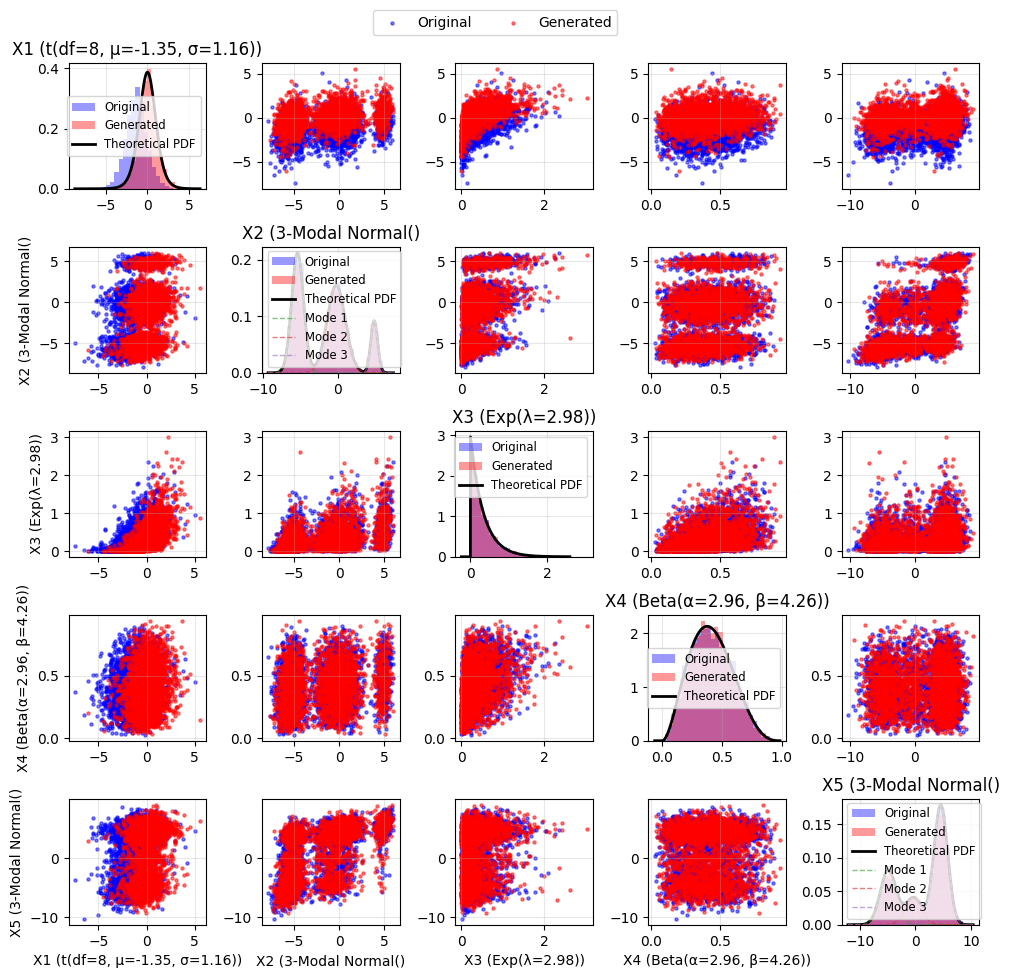

In [ ]:
visualize_mixed_data3(mixed_samples, data, model, marginals)

## Utility

In [ ]:
def visualize_mixed_data(mixed_samples, u_transformed, model=None, marginals=None):
    """Visualize mixed data with different marginal distributions in a grid of plots."""
    n_vars = len(marginals)

    # Create a grid of subplots
    fig, axes = plt.subplots(n_vars, n_vars, figsize=(n_vars*2, n_vars*2))
    var_names = [f'X{i+1} ({m["name"]})' for i, m in enumerate(marginals)]


    # Define distribution PDF and CDF mapping functions
    dist_funcs = {
        'exponential': {
            'pdf': lambda x, p: stats.expon.pdf(x, scale=p.get('scale', 1.0)),
            'ppf': lambda u, p, n: -torch.log(1 - u) * p.get('scale', 1.0)
        },
        'beta': {
            'pdf': lambda x, p: stats.beta.pdf(x, p.get('a', 1.0), p.get('b', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.beta.ppf(uk.item(), p.get('a', 1.0), p.get('b', 1.0))
                                               for uk in u], dtype=torch.float32)
        },

        't': {
            'pdf': lambda x, p: stats.t.pdf((x - p.get('loc', 0)) / p.get('scale', 1), p.get('df', 5)) / p.get('scale', 1),
            'ppf': lambda u, p, n: torch.tensor([stats.t.ppf(uk.item(), p.get('df', 5)) * p.get('scale', 1) + p.get('loc', 0) for uk in u], dtype=torch.float32)
        },
        'gamma': {
            'pdf': lambda x, p: stats.gamma.pdf(x, p.get('shape', 1.0), scale=p.get('scale', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.gamma.ppf(uk.item(), p.get('shape', 1.0), scale=p.get('scale', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        'normal': {
            'pdf': lambda x, p: stats.norm.pdf(x, p.get('loc', 0.0), p.get('scale', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.norm.ppf(uk.item(), p.get('loc', 0.0), p.get('scale', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        'lognormal': {
            'pdf': lambda x, p: stats.lognorm.pdf(x, s=p.get('s', 1.0), scale=p.get('scale', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.lognorm.ppf(uk.item(), s=p.get('s', 1.0), scale=p.get('scale', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        'weibull': {
            'pdf': lambda x, p: stats.weibull_min.pdf(x, p.get('c', 1.0), scale=p.get('scale', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.weibull_min.ppf(uk.item(), p.get('c', 1.0), scale=p.get('scale', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        'uniform': {
            'pdf': lambda x, p: stats.uniform.pdf(x, p.get('loc', 0.0), p.get('scale', 1.0) ),
            'ppf': lambda u, p, n: p.get('loc', 0.0) + p.get('scale', 1.0)  * u
        }
    }

    # Generate samples from model if provided
    if model is not None:
        with torch.no_grad():
            n_samples = len(mixed_samples)
            u_samples = model.sample(n_samples)

            # Transform uniform samples to match original distributions
            mixed_generated = torch.zeros_like(mixed_samples)

            for var_idx in range(n_vars):
                dist_type = marginals[var_idx]['type'].lower()
                params = marginals[var_idx]['params']

                # Get the appropriate ppf function or default to normal
                ppf_func = dist_funcs.get(dist_type, {}).get('ppf',
                                        lambda u, p, n: torch.tensor([stats.norm.ppf(uk.item(), 0, 1)
                                                                     for uk in u], dtype=torch.float32))

                # Apply inverse CDF transformation
                mixed_generated[:, var_idx] = ppf_func(u_samples[:, var_idx], params, n_samples)

    # Plot the grid
    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j]

            if i == j:  # Diagonal: histogram and PDF
                # ax.hist(mixed_samples[:, i].numpy(), bins=25, alpha=0.7, density=True, color='blue')
                ax.hist(mixed_generated[:, i].numpy(), bins=25, alpha=0.7, density=True, color='blue')

                if marginals is not None:
                    try:
                        # Generate x values for PDF plotting
                        x_min, x_max = np.min(mixed_samples[:, i].numpy()), np.max(mixed_samples[:, i].numpy())
                        x_range = x_max - x_min
                        x = np.linspace(x_min - 0.1*x_range, x_max + 0.1*x_range, 1000)

                        # Get distribution type and parameters
                        dist_type = marginals[i]['type'].lower()
                        params = marginals[i]['params']

                        # Get the appropriate pdf function or default to None
                        pdf_func = dist_funcs.get(dist_type, {}).get('pdf')

                        # Plot the PDF if available
                        if pdf_func is not None:
                            pdf = pdf_func(x, params)
                            ax.plot(x, pdf, 'r-', lw=2, label='Theoretical PDF')
                            ax.legend()
                    except Exception as e:
                        print(f"Error plotting PDF for {var_names[i]}: {e}")

                ax.set_title(var_names[i])

            else:  # Off-diagonal: scatter plots
                # Plot original data
                ax.scatter(
                    mixed_samples[:, j].numpy(),
                    mixed_samples[:, i].numpy(),
                    alpha=0.5, s=5, color='blue', label='Original'
                )

                # Plot generated data if model is provided
                if model is not None:
                    ax.scatter(
                        mixed_generated[:, j].numpy(),
                        mixed_generated[:, i].numpy(),
                        alpha=0.5, s=5, color='red', label='Generated'
                    )

    # Add legend to one plot
    axes[0, 1].legend(loc='upper right')
    plt.tight_layout()
    return None


In [ ]:
class NDimensionalCVineCopula(nn.Module):
    def __init__(self, n_dimensions, copula=GaussianCopula):
        super().__init__()
        self.n_dimensions = n_dimensions

        # We need copulas for each tree level and each pair within that level
        self.copulas = nn.ModuleDict()

        # For each tree level (conditioning variables)
        for tree_level in range(n_dimensions - 1):
            # The root node for this tree is tree_level + 1 (1-indexed)
            root = tree_level + 1

            # For each pair in this tree
            for j in range(root + 1, n_dimensions + 1):
                # Create key based on variables and conditioning variables
                if tree_level == 0:
                    # First tree level has no conditioning
                    key = f"c{root}{j}"
                else:
                    # Other tree levels have conditioning variables
                    conditioning = "".join([str(k) for k in range(1, tree_level + 1)])
                    key = f"c{root}{j}_{conditioning}"

                # Create the copula
                self.copulas[key] = copula()

    def forward(self, u_data):
        # Compute the density of the C-vine copula.
        batch_size = u_data.shape[0]
        # Split u_data into separate tensors for each dimension (convert to 1-indexed)
        u = [None]  # Placeholder for 1-indexing
        for i in range(self.n_dimensions):
            u.append(u_data[:, i])

        # We'll store all the h-function evaluations for reuse
        h_functions = {}

        # Initialize log density
        log_density = torch.zeros(batch_size, device=u_data.device)

        # For each tree level
        for tree_level in range(self.n_dimensions - 1):
            # The root node for this tree is tree_level + 1 (1-indexed)
            root = tree_level + 1

            # For each pair in this tree
            for j in range(root + 1, self.n_dimensions + 1):
                if tree_level == 0:
                    # First tree level has no conditioning
                    key = f"c{root}{j}"
                    copula_density = self.copulas[key](u[root], u[j])
                    log_density += torch.log(copula_density)

                    # Compute and store h-functions for the next tree level
                    h_key = f"F{j}_{root}"
                    h_functions[h_key] = self.copulas[key].h_function(u[j], u[root])
                else:
                    # Other tree levels have conditioning variables
                    conditioning = "".join([str(k) for k in range(1, tree_level + 1)])
                    key = f"c{root}{j}_{conditioning}"

                    # Get the input h-functions from the previous level
                    h_key_root = f"F{root}_{conditioning}"
                    h_key_j = f"F{j}_{conditioning}"

                    # Compute the copula density
                    copula_density = self.copulas[key](h_functions[h_key_root], h_functions[h_key_j])
                    log_density += torch.log(copula_density)

                    # Compute and store h-functions for the next tree level
                    if tree_level < self.n_dimensions - 2:  # No need for last tree level
                        new_conditioning = conditioning + str(root)
                        h_key = f"F{j}_{new_conditioning}"
                        h_functions[h_key] = self.copulas[key].h_function(
                            h_functions[h_key_j], h_functions[h_key_root]
                        )

        return torch.exp(log_density)

    def sample(self, n_samples):
        # Generate samples from the C-vine copula.
        device = next(self.parameters()).device

        # Initialize arrays to store the final u values (convert to 1-indexed)
        u = [None]  # Placeholder for 1-indexing
        u.append(torch.rand(n_samples, device=device))  # First variable
        for i in range(2, self.n_dimensions + 1):
            u.append(torch.zeros(n_samples, device=device))  # Will be filled later

        # We'll store all the h-function evaluations for reuse
        h_functions = {}

        # Generate random samples for all copulas
        # The total number of copulas needed is sum(1, 2, ..., n-1)
        n_copulas = sum(range(1, self.n_dimensions))
        w_samples = torch.rand(n_copulas, n_samples, device=device)
        w_idx = 0

        # First tree: Sample directly from the bivariate copulas with node 1 as root
        for j in range(2, self.n_dimensions + 1):
            key = f"c1{j}"
            u[j] = self.copulas[key].hinv_function(w_samples[w_idx], u[1])
            w_idx += 1

            # Store h-function for the next tree
            h_key = f"F{j}_1"
            h_functions[h_key] = self.copulas[key].h_function(u[j], u[1])

        # For each tree level beyond the first
        for tree_level in range(1, self.n_dimensions - 1):
            # The root node for this tree
            root = tree_level + 1

            # For each pair in this tree
            for j in range(root + 1, self.n_dimensions + 1):
                # Get the conditioning variables
                conditioning = "".join([str(k) for k in range(1, tree_level + 1)])
                key = f"c{root}{j}_{conditioning}"

                # Get the h-functions from the previous level
                h_key_root = f"F{root}_{conditioning}"
                h_key_j = f"F{j}_{conditioning}"

                # Update the conditional distribution using the next random variable
                h_j_new = self.copulas[key].hinv_function(w_samples[w_idx], h_functions[h_key_root])
                w_idx += 1

                # Store for the next tree level
                if tree_level < self.n_dimensions - 2:
                    new_conditioning = conditioning + str(root)
                    h_key_new = f"F{j}_{new_conditioning}"
                    h_functions[h_key_new] = self.copulas[key].h_function(
                        h_j_new, h_functions[h_key_root]
                    )

                # Propagate this change backward through the vine to update u[j]
                # Start with the current tree level and work backwards
                curr_h = h_j_new

                for k in range(tree_level, 0, -1):
                    if k == 1:
                        # Update u[j] using the first tree
                        first_key = f"c1{j}"
                        u[j] = self.copulas[first_key].hinv_function(curr_h, u[1])
                    else:
                        # Use the previous level's conditioning
                        prev_level = k - 1
                        prev_conditioning = "".join([str(i) for i in range(1, prev_level + 1)])
                        prev_key = f"c{prev_level+1}{j}_{prev_conditioning}"
                        prev_h_key = f"F{prev_level+1}_{prev_conditioning}"

                        # Update the h-function to carry back through the vine
                        curr_h = self.copulas[prev_key].hinv_function(curr_h, h_functions[prev_h_key])

        # Convert from 1-indexed to 0-indexed for the final result
        return torch.stack([u[i] for i in range(1, self.n_dimensions + 1)], dim=1)




In [ ]:
def generate_correlation_matrix(n, min_corr=-0.8, max_corr=0.8, min_abs_corr=0.05, seed=None):
    """
            Generate a valid random correlation matrix of size n x n that is strictly positive-definite,
    suitable for use with MultivariateNormal distributions.

    The function allows for some correlations to be exactly zero, but ensures non-zero
    correlations have a minimum absolute value to avoid very small correlations.

    Parameters:
    -----------
    n : int
        Dimension of the correlation matrix
    min_corr : float, optional
        Minimum correlation value (default: -0.8)
    max_corr : float, optional
        Maximum correlation value (default: 0.8)
    min_abs_corr : float, optional
        Minimum absolute correlation value (default: 0.05)
        Any non-zero correlation with absolute value below this will be adjusted to this value
        Exactly zero correlations will remain zero
    seed : int, optional
        Random seed for reproducibility

    Returns:
    --------
    torch.Tensor
        A valid positive-definite correlation matrix of size n x n
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    # Method: Generate a matrix from random data to ensure positive definiteness
    # Generate random data
    X = torch.randn(n * 10, n)  # Create random data (more samples than dimensions)

    # Compute correlation matrix from this data (this will be PD if n*10 > n)
    A = torch.corrcoef(X.T)

    # At this point, A is a valid correlation matrix (positive definite)
    # Now we'll modify it to get the desired correlation ranges while preserving its structure

    # Extract the off-diagonal elements
    off_diag_mask = ~torch.eye(n, dtype=bool)
    target_range = max_corr - min_corr
    current_min = torch.min(A[off_diag_mask]).item()
    current_max = torch.max(A[off_diag_mask]).item()
    current_range = current_max - current_min

    # Scale the off-diagonal elements to match the desired range
    if current_range > 0:  # Avoid division by zero
        A_scaled = torch.eye(n)
        scaled_values = (A[off_diag_mask] - current_min) / current_range * target_range + min_corr
        A_scaled[off_diag_mask] = scaled_values
    else:
        # If all correlations are the same, set to the mid-point of the desired range
        mid_corr = (max_corr + min_corr) / 2
        A_scaled = torch.eye(n)
        A_scaled[off_diag_mask] = mid_corr

    # Now we need to make sure the matrix is still positive definite
    # We'll use the fact that A + αI is positive definite for sufficiently large α
    eigvals = torch.linalg.eigvalsh(A_scaled)
    min_eigval = torch.min(eigvals).item()

    if min_eigval <= 0:
        # Add a small value to the diagonal to make it positive definite
        # We'll then rescale to ensure the diagonal is 1 again
        alpha = abs(min_eigval) + 0.01  # Buffer to ensure positive definiteness
        A_scaled = A_scaled + alpha * torch.eye(n)

        # Rescale to make the diagonal 1
        D_inv_sqrt = torch.diag(1.0 / torch.sqrt(torch.diag(A_scaled)))
        A_scaled = D_inv_sqrt @ A_scaled @ D_inv_sqrt

    # Apply minimum absolute correlation threshold
    if min_abs_corr > 0:
        # Get mask for off-diagonal elements
        off_diag_mask = ~torch.eye(n, dtype=bool)

        # Apply sign-preserving minimum absolute value
        off_diag_values = A_scaled[off_diag_mask]
        signs = torch.sign(off_diag_values)
        abs_values = torch.abs(off_diag_values)

        # Elements with absolute value below threshold (but not zero) get adjusted to the threshold
        # while preserving their sign. Zero values remain zero.
        small_corr_mask = (abs_values < min_abs_corr) & (abs_values > 0)
        if torch.any(small_corr_mask):
            adjusted_values = abs_values.clone()
            adjusted_values[small_corr_mask] = min_abs_corr
            A_scaled[off_diag_mask] = signs * adjusted_values

    # Verify positive definiteness one more time
    eigvals = torch.linalg.eigvalsh(A_scaled)
    min_eigval = torch.min(eigvals).item()

    # If needed, we can shrink the off-diagonal elements to ensure PD
    if min_eigval <= 0:
        # Use convex combination with identity matrix to ensure PD
        # (1-t)A + tI for t ∈ (0,1)
        t = 0.05  # Small shrinkage parameter
        while min_eigval <= 0 and t < 1.0:
            A_scaled = (1 - t) * A_scaled + t * torch.eye(n)
            eigvals = torch.linalg.eigvalsh(A_scaled)
            min_eigval = torch.min(eigvals).item()
            t += 0.05

    # Final correction to ensure numerical accuracy of diagonal = 1
    A_scaled.fill_diagonal_(1.0)

    return A_scaled


In [ ]:
def generate_random_marginals(n_distributions, seed=None):
    """
    Generate random marginal distribution specifications.

    Parameters:
    -----------
    n_distributions : int
        Number of random distributions to generate

    seed : int or None, optional (default=None)
        Random seed for reproducibility

    Returns:
    --------
    marginal_specs : list of dict
        List of dictionaries specifying the marginal distributions
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Available distribution types
    dist_types = [
        'normal',
        'exponential',
        'beta',
        'gamma',
        't',
        'uniform',
        'lognormal',
    ]

    marginal_specs = []

    for i in range(n_distributions):
        # Randomly select a distribution type
        dist_type = random.choice(dist_types)

        # Generate random parameters based on the distribution type
        if dist_type == 'normal' or dist_type == 'gaussian':
            params = {
                'loc': random.uniform(-5, 5),
                'scale': random.uniform(0.1, 3)
            }
            name = f"Normal(μ={params['loc']:.2f}, σ={params['scale']:.2f})"

        elif dist_type == 'exponential':
            params = {
                'scale': random.uniform(0.2, 2)
            }
            name = f"Exp(λ={1/params['scale']:.2f})"

        elif dist_type == 'beta':
            params = {
                'a': random.uniform(0.5, 5),
                'b': random.uniform(0.5, 5)
            }
            name = f"Beta(α={params['a']:.2f}, β={params['b']:.2f})"

        elif dist_type == 'gamma':
            params = {
                'shape': random.uniform(0.5, 5),
                'scale': random.uniform(0.5, 2)
            }
            name = f"Gamma(k={params['shape']:.2f}, θ={params['scale']:.2f})"

        elif dist_type == 't':
            params = {
                'loc': random.uniform(-2, 2),
                'scale': random.uniform(0.5, 2),
                'df': random.randint(2, 10)
            }
            name = f"t(df={params['df']}, μ={params['loc']:.2f}, σ={params['scale']:.2f})"

        elif dist_type == 'uniform':
            loc = random.uniform(-5, 5)
            width = random.uniform(1, 5)
            params = {
                'loc': loc,
                'scale': width
            }
            name = f"Uniform({loc:.2f}, {loc+width:.2f})"

        elif dist_type == 'lognormal':
            params = {
                's': random.uniform(0.1, 1),
                'scale': random.uniform(0.5, 2)
            }
            name = f"LogNormal(σ={params['s']:.2f}, scale={params['scale']:.2f})"

        marginal_specs.append({
            'name': name,
            'type': dist_type,
            'params': params
        })

    return marginal_specs



## Copula

In [ ]:

class ClaytonCopula(nn.Module):
    def __init__(self, init_theta=1.0):
        super().__init__()
        self.theta_log = nn.Parameter(torch.tensor([np.log(max(init_theta, 0.1))], dtype=torch.float32))

    def get_theta(self):
        return torch.exp(self.theta_log) + 1e-5

    def forward(self, u, v):
        theta = self.get_theta()
        log_density = torch.log1p(theta) - (1.0 + 2.0 * theta) * torch.log(
            torch.pow(u, -theta) + torch.pow(v, -theta) - 1.0 + 1e-10
        ) / theta - (theta + 1.0) * (torch.log(u) + torch.log(v))

        return torch.exp(log_density)

    def h_function(self, v, u):
        # h-function for Clayton copula: conditional CDF F(v|u)
        theta = self.get_theta()
        h = torch.pow(1.0 + torch.pow(u, theta) * (torch.pow(v, -theta) - 1.0), -1.0 - 1.0/theta)
        return h

    def hinv_function(self, w, u):
        # Inverse h-function for Clayton copula
        theta = self.get_theta()
        term1 = torch.pow(w, -theta / (1.0 + theta)) - 1.0
        term2 = term1 * torch.pow(u, -theta) + 1.0
        v = torch.pow(term2, -1.0 / theta)

        return v



## Visualization

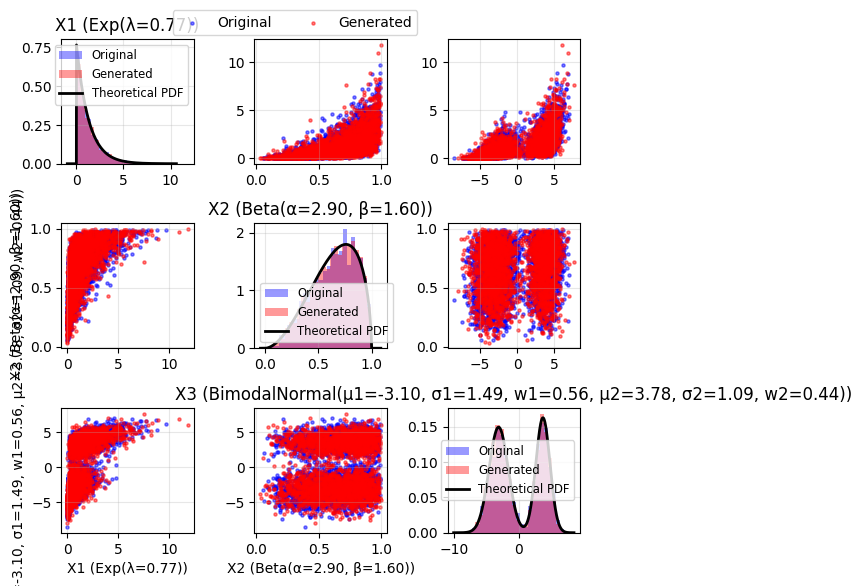

In [ ]:
visualize_mixed_data2(mixed_samples, data, model, marginals)